# ASL w/ Pre Trained Models


## Introduction

For many deaf persons in North America, American Sign Language (ASL) serves as their primary form of communication. The creation of computer vision systems that convert sign language to spoken English has advanced significantly recently.

In my most recent project, I developed an image classifier using convolutional neural networks. The language ASl is incredibly complicated, and some of the letters have an uncanny resemblance. For instance, the positioning of the thub is what makes the letters A and S different. The letters M and N also have a lot in common. This causes certain problems with image classification.

It is often possible to apply the weights and biases that emerge during image classification on additional image datasets. We can train our ASl image classifier using the same models, weights, and biases. Pre-trained models are exactly what the title implies, and they frequently produce excellent results while preserving training time and computer resources.


## Loading Dependencies and the Dataset

In [ ]:
import os
!pip install -q kaggle #import kaggle api

from google.colab import files

if os.path.exists('/content/kaggle.json') == False:
  files.upload()

!cp kaggle.json ~/.kaggle/ #copy kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json #change the permision of the file

#test that everything is running ok
!kaggle datasets download -d grassknoted/asl-alphabet
!unzip asl-alphabet.zip

In [ ]:
!pip install keras.applications

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.9 MB/s 


In [ ]:
import os 
import numpy as np
from numpy.random import seed

import tensorflow as tf
import itertools


import cv2 #for reading images using path

from sklearn.model_selection import train_test_split #test train split
from sklearn.utils import shuffle #shuffle data

import matplotlib.pyplot as plt #for plotting & data visualization

#for building a CNN using keras
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import Flatten, Dense
from keras.models import Sequential

#for error analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay

#Importing pre trained models from keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model
from keras.preprocessing import image

I'll load the ASL alphabet dataset in the code below. To train the traditional neural network, this dataset will be utilized.

In [ ]:
train_dir = "/content/asl_alphabet_train/asl_alphabet_train"
test_dir = "/content/asl_alphabet_test/asl_alphabet_test"

## Loading the Data 

We will load the training data in the code below. We will make two lists, one with photos and the other with labels, using the training data.

Once we have the labels and pictures, we can use that information to build a train-test split.

It is crucial to consider how many photographs you want to utilize. In some circumstances, you might want to simply keep the photos with the most distinctive qualities. However, in this instance, I'm going to utilize all the photos in the dataset in order to preserve as much variety as possible.


In [ ]:
def load_images(directory): #load the images and labels
    images = []
    labels = []
    for i, label in enumerate(uniq):
      count = 0
      for file in os.listdir(directory + "/" + label):
          filepath = directory + "/" + label + "/" + file
          image = cv2.resize(cv2.imread(filepath), (64, 64)) # resize image for faster processing
          images.append(image)
          labels.append(i)
          
          #added this because collab ram crashes
          count += 1 
          if count >= 1000: 
            break
    images = np.array(images)
    labels = np.array(labels)
    return(images, labels)

Since we have now taken the images and labels out of the dataset, we can utilize them to determine the train-test split.

As usuall we will split the data into x_train, y_train, x_test and y_test. It is important to devide the dataset evenly in order to achieve this i will be using the stratify argument. This argument will maintaining the same proportions of samples in each class as shown in the original dataset.

In [ ]:
uniq = sorted(os.listdir(train_dir)) #find uniq images in train data
images, labels = load_images(directory = train_dir)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)

#print size of labels and images
print('Num of uniq labels: ', len(uniq))
print('Num of training images: ', len(X_train))
print('Num of testing images: ', len(X_test))


Num of uniq labels:  29
Num of training images:  23200
Num of testing images:  5800


We can start looking at the photos now that the train test split is finished. We can see that our dataset is pretty large, therefore it would be wise to merely look at a few pictures and draw conclusions about the others.

## Data Analysis and Baseline

Let's begin by examining each letter in the alphabet. This may be achieved by placing a label next to a picture of an ASL image. Here we can see each unique label in our datset.

We can better comprehend the data we are working with by plotting these photographs along the appropriate class axis. This data visualization helps us understand the significance of the data and allows us to spot trends.

Training Images: 


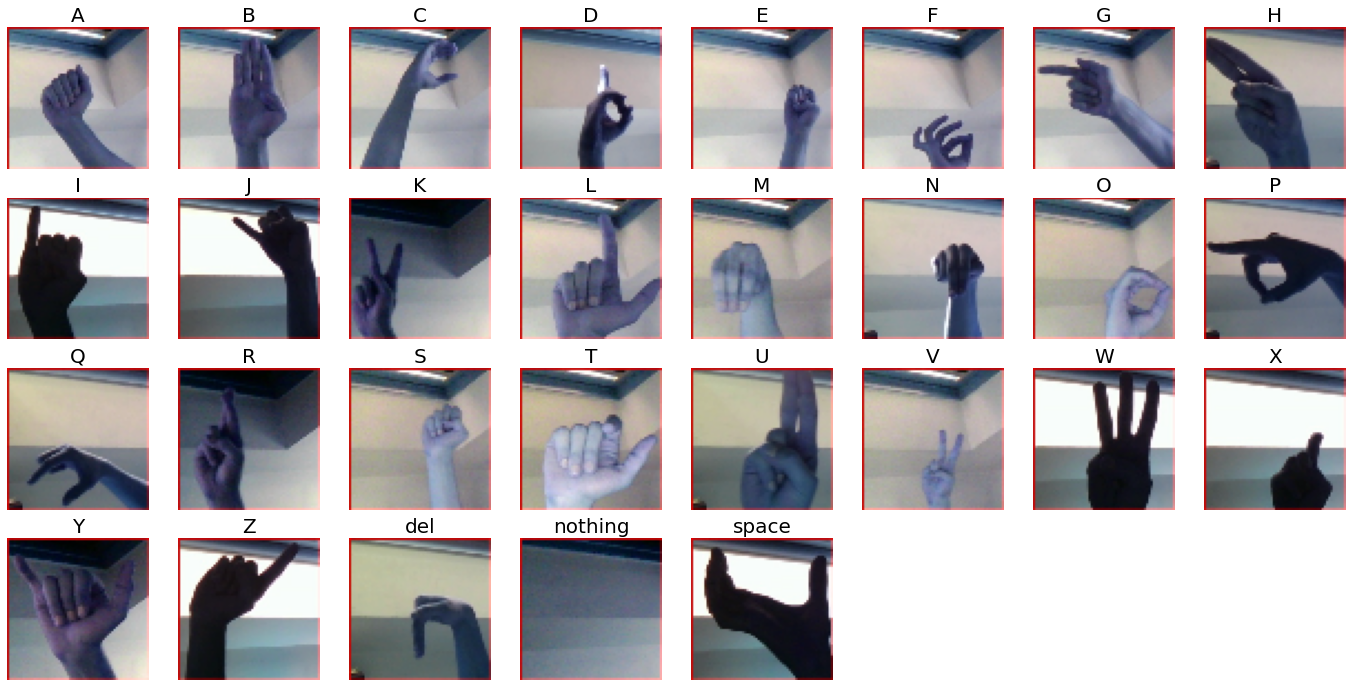

In [ ]:
def print_images(image_list):
    n = int(len(image_list) / len(uniq))
    cols = 8
    rows = 4
    fig = plt.figure(figsize = (24, 12))

    for i in range(len(uniq)):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(image_list[int(n*i)])
        plt.title(uniq[i])
        ax.title.set_fontsize(20)
        ax.axis('off')
    plt.show()

y_train_in = y_train.argsort()
y_train = y_train[y_train_in]
X_train = X_train[y_train_in]

print("Training Images: ")
print_images(image_list = X_train)

Considering that there are 29 distinct photos in the collection, useing random probability. The odds of selecting any specific letter at any moment is 1 in 29. This indicates that the likelihood of correctly predicting a particular label if you make a random guess is just approximately 3.5%.

## Pre-Processing and Pre-Trained Models

Lets start by adding one hot encoding to our labels. The labels one-dimensional array will be transformed into a two-dimensional array by this conversion. A different label is associated with each row in the two-dimensional array of one-hot encoded labels.

In [ ]:
y_train = keras.utils.to_categorical(y_train, 29)
y_test = keras.utils.to_categorical(y_test, 29)

print(y_train[0])
print(len(y_train[0]))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
29


Let's start by adding some normalization, which will help us get rid of image distortions that can be brought by by a variety of factors, including lighting, hand location, shadows, reflections, and more.

In [ ]:
X_train = np.array(X_train).astype('float32')/255.0
X_test = np.array(X_test).astype('float32')/255.0

Now that we have organized our data a bit we can start looking into building our models.

### VGG16

Here we are going to initialize our model that we pulled from keras. This is VGG16 pre-trained model. 

In [ ]:
model_vgg16 = VGG16(input_shape= (64,64,3),include_top=False,weights='imagenet')

VGG-16 is a 16-layer convolutional neural network. Additionally, it may be used to categorize photos into 1000 separate groups. It outperforms AlexNet by sequentially substituting numerous 33 kernel-sized filters for big kernel-sized filters (11 and 5 in the first and second convolutional layers, respectively). I'm expecting that this model will do well on our dataset considering that there are just 29 distinct categories.

In [ ]:

vgg16_classifier = model_vgg16.output

#additional regularization
vgg16_classifier = Flatten()(vgg16_classifier)
vgg16_classifier = Dense(units=256, activation='relu')(vgg16_classifier)
vgg16_classifier = Dropout(0.5)(vgg16_classifier) # dropout regularization, random neuron gets turned off
vgg16_classifier = Dense(units=29, activation='softmax')(vgg16_classifier)


model = Model(inputs = model_vgg16.input , outputs = vgg16_classifier)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

We can see that there are 16 layers by printing the model summary that are followed by some regularization using dense and dropout layers. This aids in training our model to avoid overfitting the input data.

In [ ]:
history = model.fit(X_train, y_train, epochs =10, batch_size = 64, validation_data=(X_test,y_test))

Epoch 1/10
363/363 [==============================] - 38s 96ms/step - loss: 2.6608 - accuracy: 0.1942 - val_loss: 1.5660 - val_accuracy: 0.5084
Epoch 2/10
363/363 [==============================] - 32s 88ms/step - loss: 0.8725 - accuracy: 0.7042 - val_loss: 0.3035 - val_accuracy: 0.8993
Epoch 3/10
363/363 [==============================] - 32s 89ms/step - loss: 0.3253 - accuracy: 0.8916 - val_loss: 0.2839 - val_accuracy: 0.9038
Epoch 4/10
363/363 [==============================] - 32s 89ms/step - loss: 0.1896 - accuracy: 0.9408 - val_loss: 0.2122 - val_accuracy: 0.9312
Epoch 5/10
363/363 [==============================] - 32s 88ms/step - loss: 0.1508 - accuracy: 0.9555 - val_loss: 0.0792 - val_accuracy: 0.9741
Epoch 6/10
363/363 [==============================] - 32s 88ms/step - loss: 0.1017 - accuracy: 0.9702 - val_loss: 0.1118 - val_accuracy: 0.9638
Epoch 7/10
363/363 [==============================] - 32s 88ms/step - loss: 0.1174 - accuracy: 0.9669 - val_loss: 0.1370 - val_accuracy:

Here, we can observe that after 10 epochs, the model accuracy is roughly 97%. This exhibits really good outcomes, which in fact outperform those of the traditional neural network that we constructed in the past.

The fact that we gave the model all of the images in the dataset this time around rather than using a smaller sample size is another indication that the model is correctly training.

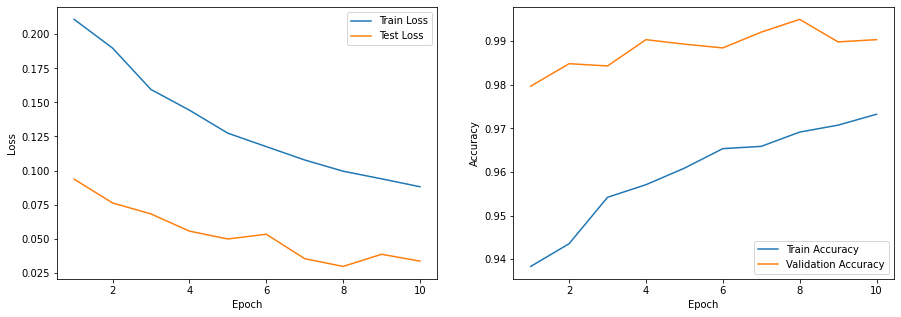

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

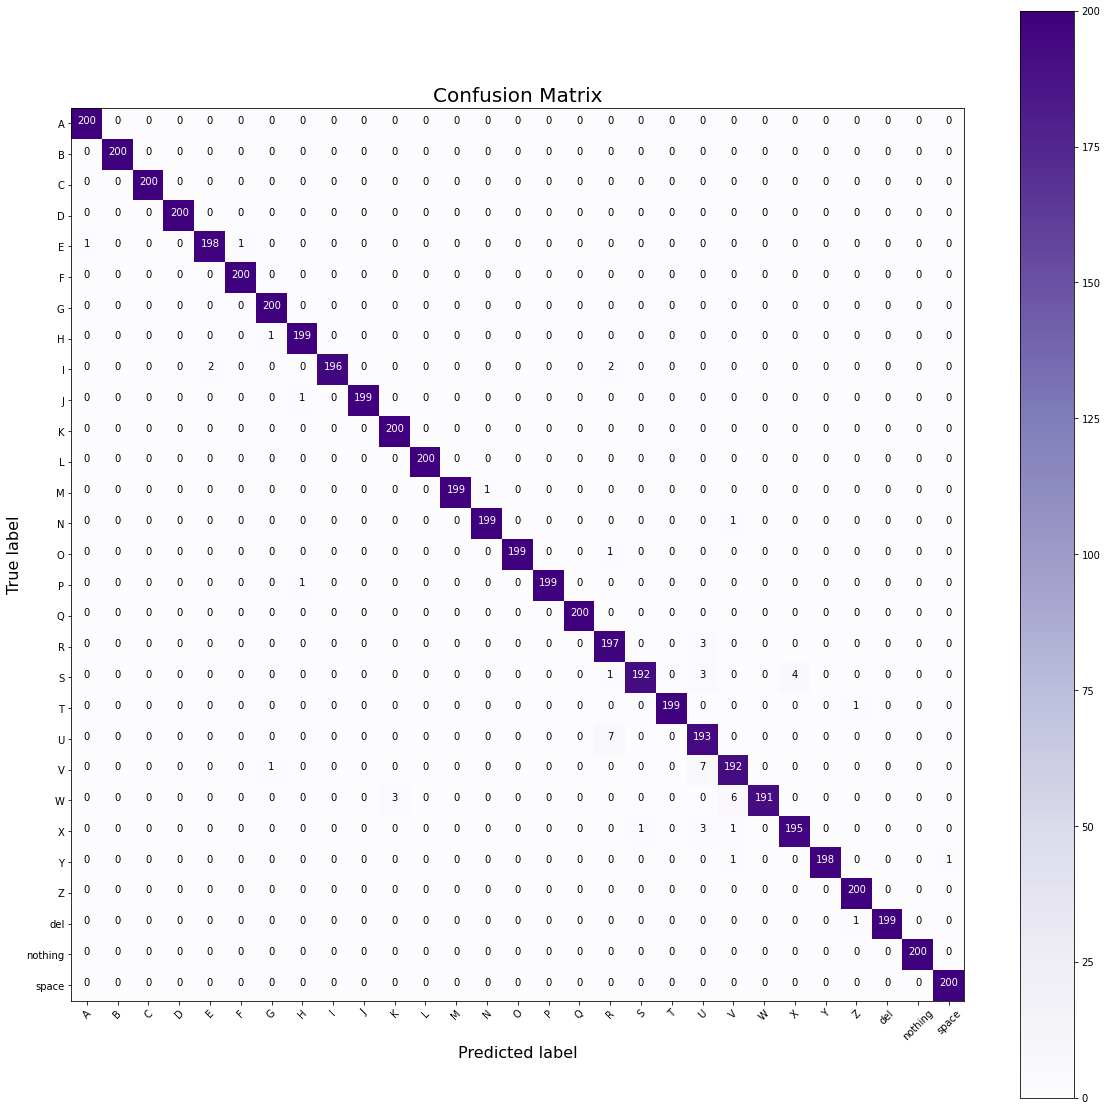

In [ ]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (20, 20))

    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq))

    plt.xticks(tick_marks, uniq, rotation=45)
    plt.yticks(tick_marks, uniq)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)

    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

We may have a better understanding of the correctness of the model by formulating the confusion matrices.

Even though the model outperforms our prior convolutional neural network, we can still detect certain patterns in the errors it commits.

The model in our previous CNN struggled to tell Us from Vs since they are so close in resembalance. The identical error occurs here, but it does so much less frequently.

### RESNET50


Here, we'll initialize the model we downloaded from Keras. This convolutional neural network, ResNet50, has 50 layers.

The term "ResNet" refers to a neural network that was very recently developed by He Kaiming, Zhang Xiangyu, Ren Shaoqing, and Sun Jian in 2015. It is a synthetic neural network that builds networks out of leftover components.

In [ ]:
model_resnet = ResNet50(input_shape= (64,64,3),include_top=False,weights='imagenet')

In [ ]:
resnet50_classifier = model_resnet.output
resnet50_classifier = Flatten()(resnet50_classifier)
resnet50_classifier = Dropout(0.5)(resnet50_classifier)
resnet50_classifier = Dense(units=29, activation='softmax')(resnet50_classifier)

model1 = Model(inputs = model_resnet.input , outputs = resnet50_classifier)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['input_6[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
history = model1.fit(X_train, y_train, epochs =10, batch_size = 64, validation_data=(X_test,y_test))

Epoch 1/10
363/363 [==============================] - 41s 92ms/step - loss: 1.6318 - accuracy: 0.6669 - val_loss: 534.5091 - val_accuracy: 0.0345
Epoch 2/10
363/363 [==============================] - 31s 86ms/step - loss: 0.2717 - accuracy: 0.9225 - val_loss: 5.1781 - val_accuracy: 0.0984
Epoch 3/10
363/363 [==============================] - 31s 86ms/step - loss: 0.3049 - accuracy: 0.9277 - val_loss: 0.8986 - val_accuracy: 0.8831
Epoch 4/10
363/363 [==============================] - 31s 87ms/step - loss: 0.2470 - accuracy: 0.9503 - val_loss: 2.5357 - val_accuracy: 0.5928
Epoch 5/10
363/363 [==============================] - 31s 86ms/step - loss: 0.2084 - accuracy: 0.9538 - val_loss: 0.3937 - val_accuracy: 0.9081
Epoch 6/10
363/363 [==============================] - 31s 86ms/step - loss: 0.1239 - accuracy: 0.9687 - val_loss: 0.0686 - val_accuracy: 0.9786
Epoch 7/10
363/363 [==============================] - 31s 87ms/step - loss: 0.0748 - accuracy: 0.9821 - val_loss: 0.3090 - val_accurac

We can observe that this model's accuracy is fairly comparable to that of VGG16. However, compared to VGG16, the validation loss and accuracy are much more unstable.

Plotting the loss curves according to epochs will help us examine them.

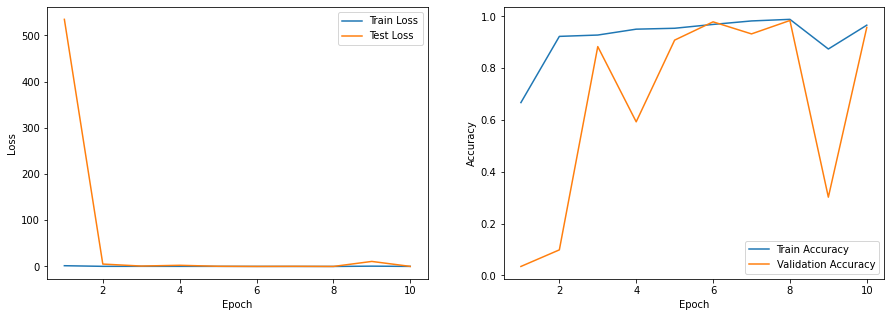

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

The train/test loss is shown to follow a 1/x curve, which is what I seek for when examining the loss curve.

However, the accuracy of training and validation is rather unstable. This shows that certain cases are categorised in a semi-random manner (unpredictable). It can also be a sign that not enough data points are available to categorize the image.

Let's print the confusion matrix to have greater understanding of the categorization faults.

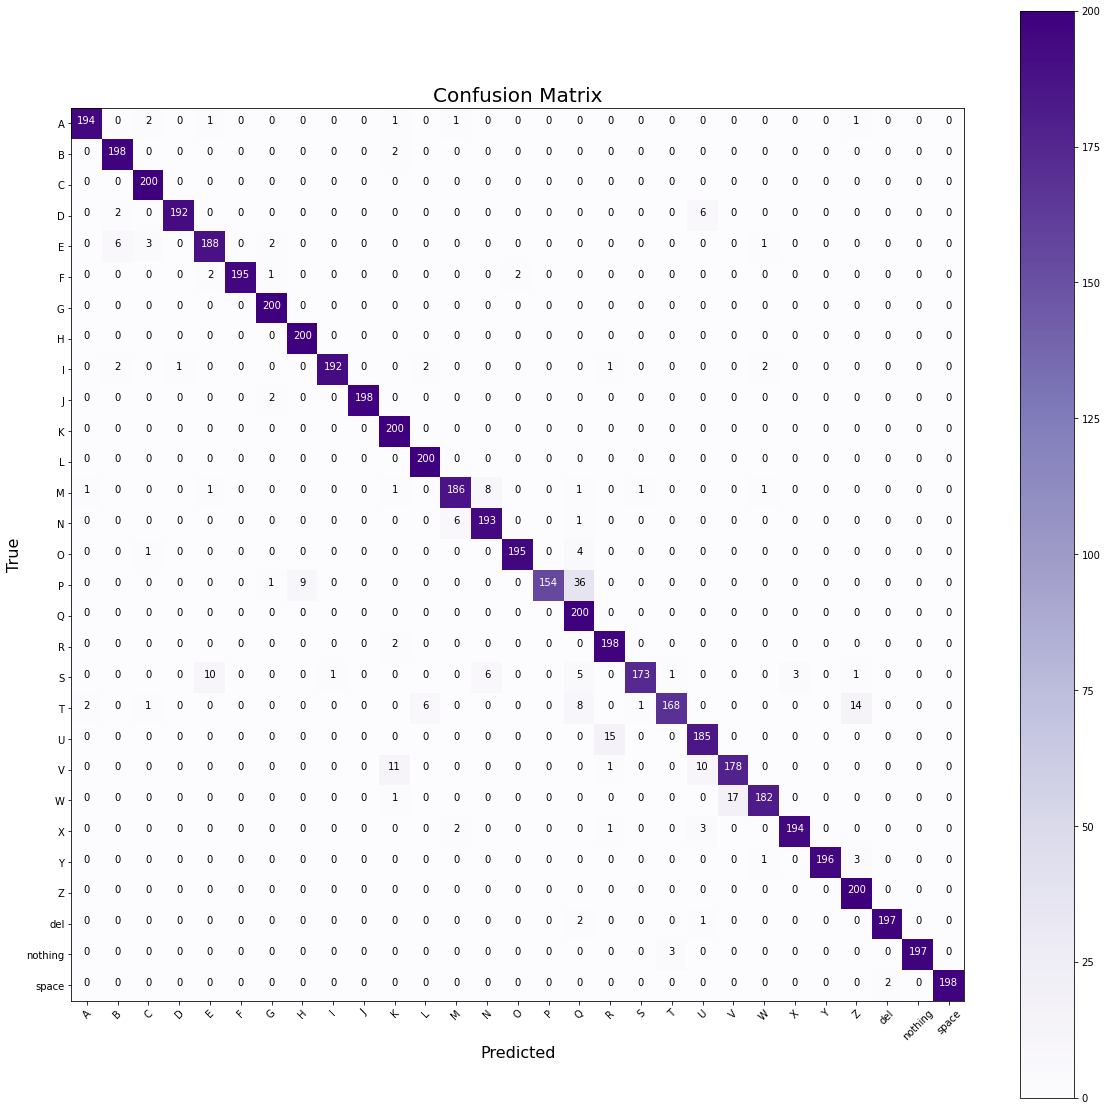

In [ ]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (20, 20))

    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq))

    plt.xticks(tick_marks, uniq, rotation=45)
    plt.yticks(tick_marks, uniq)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)

    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

y_test_pred = model1.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

We can observe by looking at the confusion matrix that there are a few missclassifications that happen regularly. It is believed that U and V frequently get confused for one another because this has happened with earlier CNNs. However, P & O's misclassification stands out as a glaring anomaly.

### MobileNet V2

Here, we'll initialize the model we downloaded from Keras. This convolutional neural network, known as MobileNet V2, aims to function well on mobile devices. Based on an inverted residual topology (similar to RESNET), the bottleneck layers are connected via residuals.

In [ ]:
model_mobilenet_v2 = MobileNetV2(input_shape= (64,64,3),include_top=False,weights='imagenet')
for layer in model_vgg16.layers:
    layer.trainable = False

In [ ]:
mobilnetv2_classifier = model_mobilenet_v2.output
mobilnetv2_classifier = Flatten()(mobilnetv2_classifier)
mobilnetv2_classifier = Dropout(0.5)(mobilnetv2_classifier)
mobilnetv2_classifier = Dense(units=29, activation='softmax')(mobilnetv2_classifier)

model2 = Model(inputs = model_mobilenet_v2.input , outputs = mobilnetv2_classifier)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 32, 32, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 32, 32, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 32, 32, 32)   0           ['bn_Conv1[0][0]']               
                                                                                            

In [ ]:
history = model2.fit(X_train, y_train, epochs =10, batch_size = 64, validation_data=(X_test,y_test))

Epoch 1/10
363/363 [==============================] - 19s 39ms/step - loss: 1.3014 - accuracy: 0.6805 - val_loss: 20.4889 - val_accuracy: 0.1284
Epoch 2/10
363/363 [==============================] - 13s 35ms/step - loss: 0.2673 - accuracy: 0.9328 - val_loss: 12.9428 - val_accuracy: 0.3590
Epoch 3/10
363/363 [==============================] - 12s 34ms/step - loss: 0.1061 - accuracy: 0.9709 - val_loss: 6.4569 - val_accuracy: 0.5467
Epoch 4/10
363/363 [==============================] - 12s 34ms/step - loss: 0.1454 - accuracy: 0.9669 - val_loss: 24.2345 - val_accuracy: 0.2571
Epoch 5/10
363/363 [==============================] - 16s 43ms/step - loss: 0.0970 - accuracy: 0.9777 - val_loss: 6.7666 - val_accuracy: 0.5719
Epoch 6/10
363/363 [==============================] - 16s 43ms/step - loss: 0.1572 - accuracy: 0.9669 - val_loss: 9.6031 - val_accuracy: 0.5878
Epoch 7/10
363/363 [==============================] - 14s 39ms/step - loss: 0.0842 - accuracy: 0.9812 - val_loss: 1.8318 - val_accura

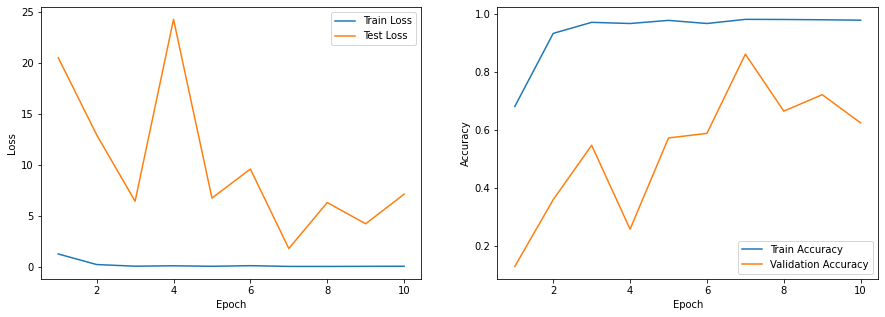

In [ ]:
#get values from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

#create a count for the number of epochs (x axis)
epoch_count = range(1, len(loss) + 1)

#train and test loss plot
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epoch_count, loss)
plt.plot(epoch_count, val_loss)
plt.legend(['Train Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

#train and val acc plot
plt.subplot(1,2,2)
plt.plot(epoch_count, accuracy)
plt.plot(epoch_count, val_accuracy)
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

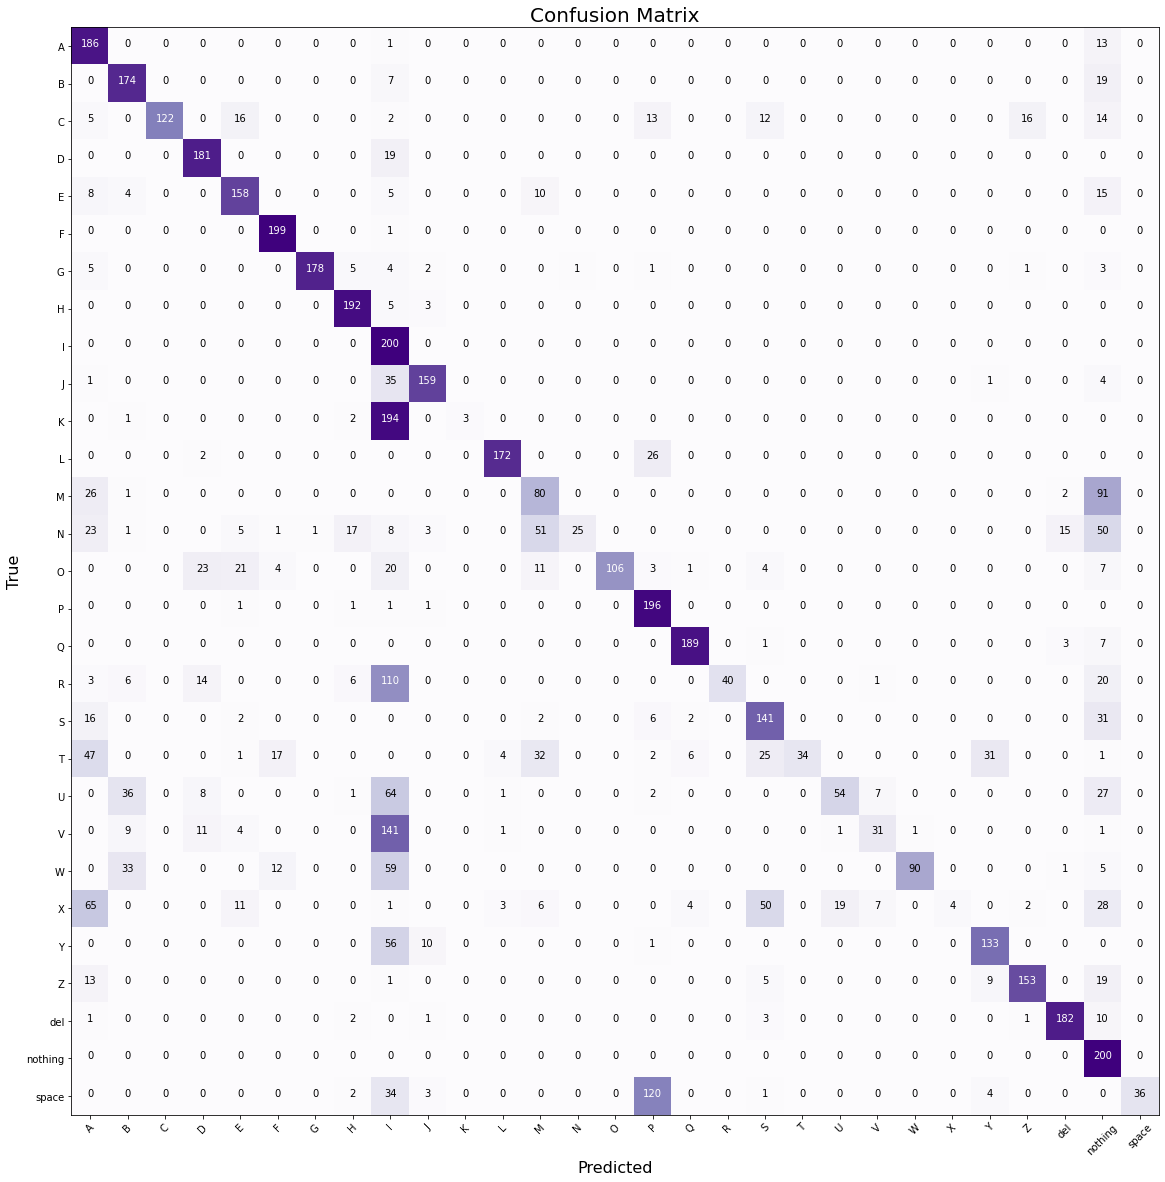

In [ ]:
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (20, 20))

    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq))

    plt.xticks(tick_marks, uniq, rotation=45)
    plt.yticks(tick_marks, uniq)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)

    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

y_test_pred = model2.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

## Conlusion

After using the same dataset to train three previously trained models, it is clear to me that certain models are clearly superior to others.

The standard neural network that I developed in my previous project is outperformed by RESNET50 and VGG16. However, MobilNetv2 consistently makes extremely obvious classification mistakes.

Being sure that the pre-trained model you have chosen has been trained on a similar data set to the one that you desire to utilize it on may be helpful when choosing these models.



